In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
import collections
%matplotlib inline

#### KEYWORDS DATA SET

Let's analyze the data set of Keywords. The target is to see what information there is, how it is structured, if there are null or empty data and finally obtain a final data set with the information that may be useful for the model

In [2]:
# # The reason you get this low_memory warning is because guessing dtypes for each column is very memory demanding. 
# Pandas tries to determine what dtype to set by analyzing the data in each column

df_keywords = pd.read_csv("the_movies_dataset/keywords.csv", low_memory = False)

In [3]:
df_keywords.head(5)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [4]:
df_keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
id          46419 non-null int64
keywords    46419 non-null object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


In [5]:
df_keywords.isnull().sum()

id          0
keywords    0
dtype: int64

After a first view of the dataframe we can see that there are 2 variables: id of the movie and the keywords.
<br>
There are 46419 records and apparently no null data
<br>
Let's see the information in the variable keywords

In [6]:
df_keywords["keywords"][0]

"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"

We can see that the information is in JSON format. There are lists of dicts.
<br>
We are going to convert the JSON data into a list of dicts. This operation we will use it more times, so we create a function.

In [7]:
def to_list(column, key):
    
    new_column = column.fillna('[]').apply(ast.literal_eval).apply(lambda x: [i[key] for i in x] 
                                                                   if isinstance(x, list) else [])
    
    return new_column

In [8]:
df_keywords["keywords"] = to_list(df_keywords["keywords"], "name")

In [9]:
df_keywords.head(5)

,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board game, disappearance, based on children'..."
2,15602,"[fishing, best friend, duringcreditsstinger, o..."
3,31357,"[based on novel, interracial relationship, sin..."
4,11862,"[baby, midlife crisis, confidence, aging, daug..."


Let's see how many keywords we have in total
<br>
For this task we will create a function that returns the list of of keywords and it's frequency. For the word count we will use the library collections

In [10]:
def word_count(dataframe, ref_variable):
    values_list = []
    
    for elements_list in dataframe[ref_variable]:
        for value in elements_list:
            values_list.append(value)
    
    return collections.Counter(values_list)

In [11]:
keywords_counter = word_count(df_keywords, "keywords")

In [12]:
print("We have %d unique keywords" %(len(keywords_counter.keys())))

We have 19956 unique keywords


Let's see the most commons keywords in a bar plot

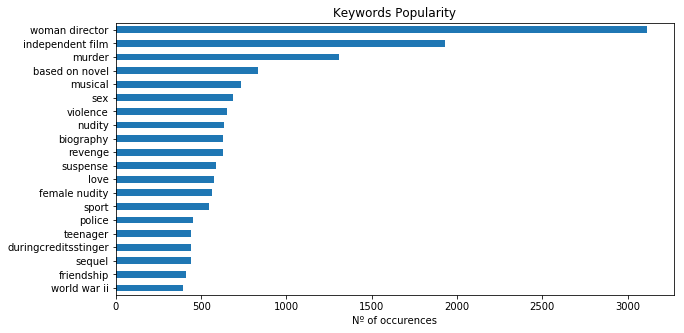

In [13]:
plt.subplots(figsize = (10, 5))

ax = pd.Series(keywords_counter).sort_values(ascending = True)[-20:].plot.barh()
ax.set_xlabel("Nº of occurences")
ax.set_title("Keywords Popularity") 

plt.show()

We have many unique keywords but we can't use all of them for the model, so let's check how many keywords we need to represent an x% of all the movies with data. (Remember that we have movies with no data of keywords)

We create a function that takes the data frame, the variable, the counter of keywords and the min x% of representation we want.
<br>
This function will return a list of the keywords needed per movie

In [14]:
def word_selector(dataframe, ref_variable, counter, criteria):
    
    # First of all we will create the list with all the words per row of the variable of the dataframe
    list_of_words = [word for word in dataframe[ref_variable]]
    
    words_df = [] # This will be the list that we return
    
    number_words = np.arange(0, 2000, 20) # This will be the number of most common words we take
    
    for n in number_words:
        most_freq_words = [word_count[0] for word_count in counter.most_common(n)]
        
        rows_with_word = 0
        rows_with_data = 0
        
        for words in list_of_words:
            
            if len(words) == 0:
                words_df.append([])
                continue
                
            else:
                rows_with_data += 1
                words_df.append(list(filter(lambda x: x in most_freq_words, words)))
                
                if any(x in most_freq_words for x in words):
                    rows_with_word += 1
                
        representation = rows_with_word / rows_with_data
        
        if representation > criteria:
            break
            
        else:
            rows_with_word = 0
            rows_with_data = 0
            words_df = []
            
    print("Words needed: %d. %.2f %% of representation" %(n, 100 * representation))
    
    return words_df

In [15]:
new_keywords = word_selector(df_keywords, "keywords", keywords_counter, 0.8)

Words needed: 400. 80.42 % of representation


If we take the 400 most common keywords we have representation of the 80% of the movies with data.
<br>
There are a total of 19956 keywords. So only with the 2% of the keywords we represent the 80% of the movies with data

In [16]:
new_keywords[:5]

[['jealousy', 'boy', 'friendship', 'friends', 'rivalry'],
 ['disappearance'],
 ['best friend', 'duringcreditsstinger'],
 ['based on novel', 'single mother', 'divorce'],
 ['baby', 'daughter', 'mother daughter relationship', 'pregnancy']]

In [17]:
# Change the column
df_keywords["keywords"] = pd.Series(new_keywords).values

In [18]:
df_keywords.head(5)

,id,keywords
0,862,"[jealousy, boy, friendship, friends, rivalry]"
1,8844,[disappearance]
2,15602,"[best friend, duringcreditsstinger]"
3,31357,"[based on novel, single mother, divorce]"
4,11862,"[baby, daughter, mother daughter relationship,..."


In [20]:
df_keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
id          46419 non-null int64
keywords    46419 non-null object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB
